# MNIST Experiment: T On 20

In [1]:
import sys
sys.path.insert(1, '../_tools/')
import torch as th
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as trasf
from utils.tensordata import TDataset, TDataloader, PosNeg_Bootstrap_TDataloader
from utils.model_selection import GridSearchCV, RandomSearchCV, Fixed, LogUniform
from twomoon import TwoMoon
from ffa import FFA_withEntropy
import matplotlib.pyplot as plt

exp_name = 'T On 20'

seed = 42
th.manual_seed(seed)
np.random.seed(seed)
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

### Data

In [2]:
DS_torch_dataset = torchvision.datasets.MNIST(
    root=r"C:\Users\matte\LocalData\Master Thesis",
    train=True,
    download=True,
    transform=trasf.ToTensor()
)
TS_torch_dataset = torchvision.datasets.MNIST(
    root=r"C:\Users\matte\LocalData\Master Thesis",
    train=False,
    download=True,
    transform=trasf.ToTensor()
)

# Load everything
DS = TDataset(
    x=th.stack([x.flatten() for x, y in DS_torch_dataset]).to(device),
    y=th.tensor([y for x, y in DS_torch_dataset], device=device).reshape(-1, 1)
)
TS = TDataset(
    x=th.stack([x.flatten() for x, y in TS_torch_dataset]).to(device),
    y=th.tensor([y for x, y in TS_torch_dataset], device=device).reshape(-1, 1)
)
TR, VL = DS.random_split(5/6)

# Dataloaders
batch_size = 128
DS_dl = DS.dataloader(batch_size=batch_size)
TR_dl = TR.dataloader(batch_size=batch_size)
VL_dl = VL.dataloader(batch_size=batch_size)
TS_dl = TS.dataloader(batch_size=batch_size)
TR_pndl = PosNeg_Bootstrap_TDataloader(TR, batch_size=batch_size)
DS_pndl = PosNeg_Bootstrap_TDataloader(DS, batch_size=batch_size)

### Model

In [3]:
Model = FFA_withEntropy

***

### Preliminary Screening

***

### Model Selection + Final Retraining

In [4]:
# Macro Grid
grid = {
    'Nclasses': [10],
    'A': [(784+10, 20, 20, 20)],
    'f_hid': [nn.ReLU()],
    'lr_hot': [0.01],
    'lr_cold': [0.01],
    'momentum': [0.99], 
    'weight_decay': [1e-6, 1e-4],
    'temperature': [0.1, 1., 10.],
    'kernel_scale': [0.3, 3., 30.],
    'Nepochs': [24]
}
ModelSelection = GridSearchCV(Model, grid, device)       
ModelSelection.run(TR_dl, VL_dl, TR_pndl)
ModelSelection.save("model selection results/" + exp_name + " - macro grid.txt")
print(ModelSelection)
print("Note: E == 1 - accuracy")

best = ModelSelection.results[0]['hyp']
# Micro grid
grid = {
    'Nclasses': [10],
    'A': [(784+10, 20, 20, 20)],
    'f_hid': [nn.ReLU()],
    'lr_hot': [0.01],
    'lr_cold': [0.01],
    'momentum': [0.99], 
    'weight_decay': [best['weight_decay']],
    'temperature': [best['temperature']/3, best['temperature'], best['temperature']*3 ],
    'kernel_scale': [best['kernel_scale']/3, best['kernel_scale'], best['kernel_scale']*3],
    'Nepochs': [24]
}
ModelSelection = GridSearchCV(Model, grid, device)       
ModelSelection.run(TR_dl, VL_dl, TR_pndl)
ModelSelection.save("model selection results/" + exp_name + " - micro grid.txt")
print(ModelSelection)
print("Note: E == 1 - accuracy")

# Final Retraining
M = Model(ModelSelection.results[0]['hyp']).to(device)
print('\n' + '-'*20 + "Final Retraining" + '-'*20)
M.fit(DS_pndl)
print(f"acc(TR) = {(1-M.TS_loop(DS_dl))*100:.3g} %")
th.save(M, 'final models/' + exp_name + '.pt')

GridSearchCV: 100%|████████████████████████████████████████████████████████████████| 18/18 [7:08:08<00:00, 1427.16s/it]


The winner is:
hyp: {
 Nclasses: 10,
 A: (794, 20, 20, 20),
 f_hid: ReLU(),
 lr_hot: 0.01,
 lr_cold: 0.01,
 momentum: 0.99,
 weight_decay: 0.0001,
 temperature: 0.1,
 kernel_scale: 30.0,
 Nepochs: 24,
}
E(VL) = 0.0774
E(TR) = 0.071
Note: E == 1 - accuracy


GridSearchCV: 100%|██████████████████████████████████████████████████████████████████| 9/9 [3:32:47<00:00, 1418.57s/it]


The winner is:
hyp: {
 Nclasses: 10,
 A: (794, 20, 20, 20),
 f_hid: ReLU(),
 lr_hot: 0.01,
 lr_cold: 0.01,
 momentum: 0.99,
 weight_decay: 0.0001,
 temperature: 0.03333333333333333,
 kernel_scale: 10.0,
 Nepochs: 24,
}
E(VL) = 0.0735
E(TR) = 0.06678
Note: E == 1 - accuracy

--------------------Final Retraining--------------------
acc(TR) = 93.3 %


***

### Analysis

Note: noisy curves are expected, due to bootstrap and random generation of different negative data at each epoch.

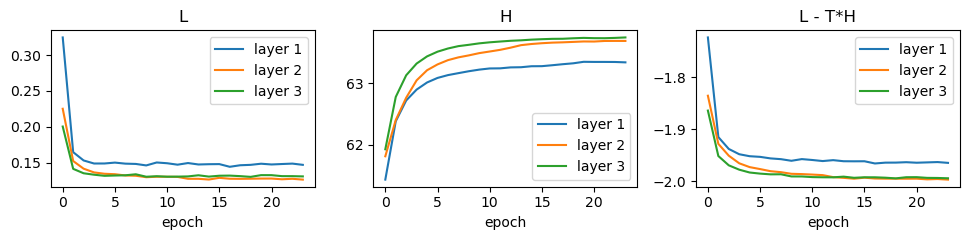

In [5]:
M = th.load('final models/' + exp_name + '.pt').to(device)
M.plot_curve()

In [6]:
gathers = [
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]   
]
print("gather     accuracy%")
for gather in gathers:
    M.gather.data = th.tensor(gather, device=device).float()
    print(f"{gather}  {(1-M.TS_loop(TS_dl))*100:.5g}")

gather     accuracy%
[1, 1, 1]  93.41
[0, 1, 1]  93.24
[1, 0, 0]  92.5
[0, 1, 0]  93
[0, 0, 1]  92.7


#### Different initializations different results?

In [7]:
M = th.load('final models/' + exp_name + '.pt').to(device)

N_trials = 5
TS_acc = []
for i in range(N_trials):
    M.fit(DS_pndl)
    this_trial_results = []
    for gather in gathers:
        M.gather.data = th.tensor(gather, device=device).float()
        this_trial_results.append((1-M.TS_loop(TS_dl))*100)   
    TS_acc.append(this_trial_results)   
TS_acc = np.asarray(TS_acc)
TS_mean = np.mean(TS_acc, axis=0)
TS_std = np.std(TS_acc, axis=0, ddof=1)

print("gather     accuracy%")
for i in range(len(gathers)):
    print(f"{gathers[i]}  {TS_mean[i]:.5g} +- {TS_std[i]:.5g}")

gather     accuracy%
[1, 1, 1]  93.358 +- 0.21371
[0, 1, 1]  93.208 +- 0.11649
[1, 0, 0]  92.5 +- 0.16583
[0, 1, 0]  92.92 +- 0.096695
[0, 0, 1]  92.39 +- 0.23854
